In [162]:
import pandas as pd

In [163]:
df = pd.read_csv('mock_fashion_data_uk_us.csv')

In [165]:
df_change = df.drop(['Product Name', 'Brand', 'Category','Description', 'Season','Review Count', 'Total Sizes', 'Purchase History',  'Fashion Influencers', 'Fashion Magazines',
'Time Period Highest Purchase','feedback','Social Media Comments', 'Customer Reviews', 'Price', 'Age'], axis = 1)

In [166]:
# Define categorical and numerical columns
categorical_columns = ['Style Attributes', 'Available Sizes', 'Color']
numerical_columns = ['Price', 'Age']  # Add other numerical columns if present


In [167]:
df_change = pd.get_dummies(df_change, columns=categorical_columns, drop_first=True)

In [168]:
df_change.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 16 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   Rating                       1000000 non-null  float64
 1   Style Attributes_Casual      1000000 non-null  bool   
 2   Style Attributes_Edgy        1000000 non-null  bool   
 3   Style Attributes_Formal      1000000 non-null  bool   
 4   Style Attributes_Glamorous   1000000 non-null  bool   
 5   Style Attributes_Minimalist  1000000 non-null  bool   
 6   Style Attributes_Preppy      1000000 non-null  bool   
 7   Style Attributes_Sporty      1000000 non-null  bool   
 8   Style Attributes_Streetwear  1000000 non-null  bool   
 9   Style Attributes_Vintage     1000000 non-null  bool   
 10  Available Sizes_M            1000000 non-null  bool   
 11  Available Sizes_S            1000000 non-null  bool   
 12  Available Sizes_XL           1000000 non-nu

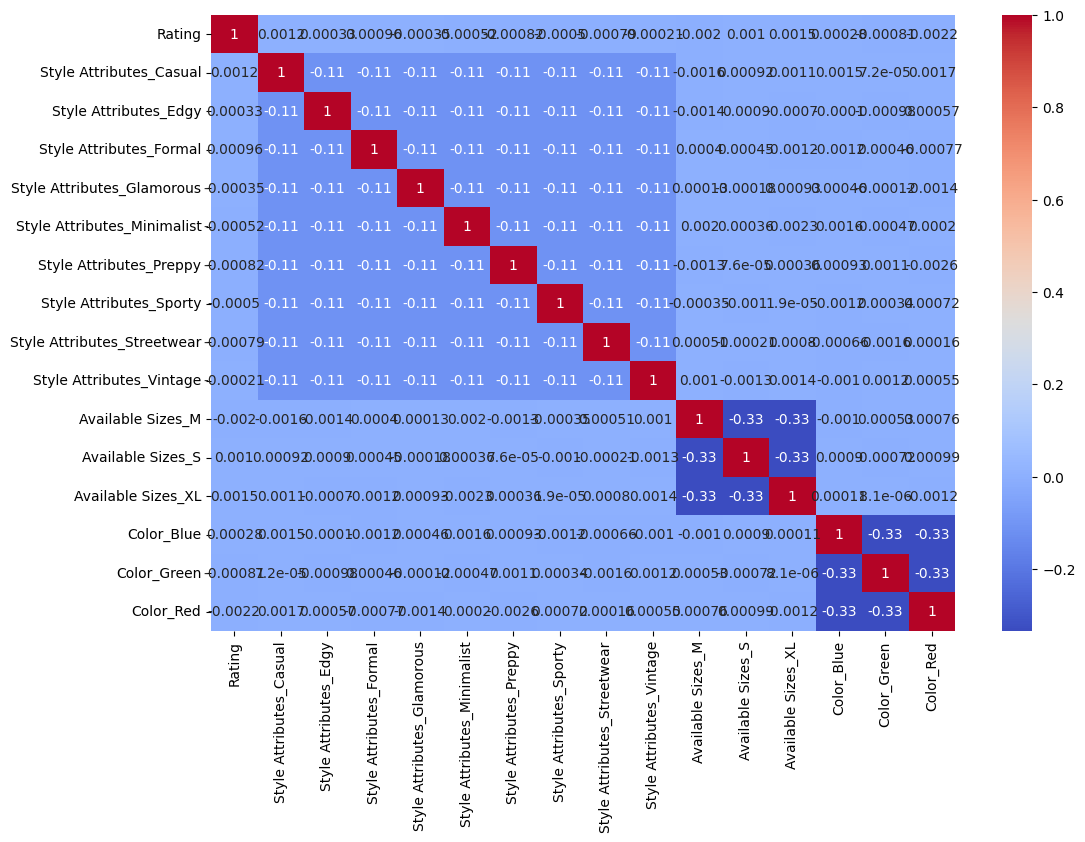

In [169]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = df_change.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# Select features that have a high correlation with 'Rating'
correlation_threshold = 0.001  # Set threshold value
relevant_features = corr_matrix.index[abs(corr_matrix['Rating']) > correlation_threshold]
df_selected = df_change[relevant_features]


In [170]:
relevant_features

Index(['Rating', 'Style Attributes_Casual', 'Available Sizes_M',
       'Available Sizes_S', 'Available Sizes_XL', 'Color_Red'],
      dtype='object')

In [183]:
df_selected = df_change

In [184]:
from sklearn.model_selection import train_test_split

# Define features and target
X = df_selected.drop('Rating', axis=1)
y = df_selected['Rating']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [185]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)


LinearRegression()

In [204]:
from sklearn.neighbors import NearestNeighbors

In [205]:
neighbors = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(X)

In [206]:
# Predict on the test set
y_pred = model.predict(X_test)

In [207]:
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

In [208]:
# Predict ratings for the entire dataset
df['Predicted Rating'] = model.predict(X)

In [209]:
import numpy as np

In [210]:
categorical_columns

['Style Attributes', 'Available Sizes', 'Color']

In [191]:
df.columns

Index(['Product Name', 'Price', 'Brand', 'Category', 'Description', 'Rating',
       'Review Count', 'Style Attributes', 'Total Sizes', 'Available Sizes',
       'Color', 'Purchase History', 'Age', 'Fashion Magazines',
       'Fashion Influencers', 'Season', 'Time Period Highest Purchase',
       'Customer Reviews', 'Social Media Comments', 'feedback',
       'Predicted Rating'],
      dtype='object')

In [211]:
def get_recommendations(style_attributes, color, size, top_n=5):
    # Create a DataFrame for the input attributes
    input_df = pd.DataFrame({
        'Style Attributes': [style_attributes],
        'Color': [color],
        'Available Sizes': [size],
        # 'Brand': [''],  # Dummy value
        # 'Category': [''],  # Dummy value
        #Fashion Influencers': [''],  # Dummy value
        # 'Season': [''],  # Dummy value
        # 'Price': [0],  # Dummy value
        # 'Age': [0],    # Dummy value
        #'Customer Reviews': [''],
        # 'Social Media Comments': ['']
    })
    
      # Apply one-hot encoding to input_df
    input_encoded = pd.get_dummies(input_df, columns=categorical_columns, drop_first=True)
    
    # Ensure all columns exist in input_encoded
    for col in X.columns:
        if col not in input_encoded.columns:
            input_encoded[col] = 0
    
    # Transform the input attributes
    input_transformed = input_encoded[X.columns].values
    
    # Calculate cosine similarity
    similarity_scores = cosine_similarity(input_transformed, X.values)
    
    # Get indices of top N most similar outfits
    top_indices = similarity_scores[0].argsort()[-top_n:][::-1]
    
    # Get the top N most similar outfits
    recommendations = df.iloc[top_indices]
    
    return recommendations

In [212]:
def get_recommendations(style_attributes, color, size, top_n=5):
    # Create a DataFrame for the input attributes
    input_df = pd.DataFrame({
        'Style Attributes': [style_attributes],
        'Color': [color],
        'Available Sizes': [size]
    })
    
    # Apply one-hot encoding to input_df
    input_encoded = pd.get_dummies(input_df, columns=['Style Attributes', 'Color', 'Available Sizes'], drop_first=True)
    
    # Ensure all columns exist in input_encoded
    for col in X.columns:
        if col not in input_encoded.columns:
            input_encoded[col] = 0
    
    # Transform the input attributes
    input_transformed = input_encoded[X.columns].values
    
    # Predict ratings using the trained model
    predicted_ratings = model.predict(input_transformed)
    
    # Add predicted ratings to input_transformed
    input_transformed_with_rating = np.hstack([input_transformed, predicted_ratings.reshape(-1, 1)])
    
    # Find the nearest neighbors
    distances, indices = neighbors.kneighbors(input_transformed)
    
    # Get the top N most similar outfits
    recommendations = df.iloc[indices[0]]
    
    return recommendations

In [214]:
# Example usage
style_attributes = 'Formal'
color = 'Black'
size = 'M'

recommendations = get_recommendations(style_attributes, color, size, top_n=5)
print(recommendations[['Product Name', 'Price', 'Brand', 'Category', 'Description', 'Rating',
       'Review Count', 'Style Attributes', 'Total Sizes', 'Available Sizes',
       'Color', 'Purchase History', 'Age', 'Fashion Magazines',
       #'Fashion Influencers', 'Season', 'Time Period Highest Purchase',
      # 'Customer Reviews', 'Social Media Comments', 'feedback',
       #'Predicted Rating'
       ]])


    Product Name      Price           Brand    Category Description    Rating  \
312         O1A0  71.996004  Tommy Hilfiger     Bottoms         Bad  2.502029   
528         Y9Z2  59.307464       Ted Baker  Activewear        Good  3.591309   
365         V7C3  67.579611        Burberry     Bottoms         Bad  1.949462   
63          X6E5  22.956415          Jigsaw    Lingerie    Very Bad  1.566964   
354         R3I8  14.872509        Burberry     Dresses    Very Bad  4.678899   

     Review Count Style Attributes Total Sizes Available Sizes  Color  \
312           228         Bohemian    M, L, XL               L  Black   
528           349         Bohemian    S, L, XL               L  Black   
365           249         Bohemian    S, L, XL               L  Black   
63            448         Bohemian    M, L, XL               L  Black   
354            84         Bohemian    S, L, XL               L  Black   

    Purchase History  Age Fashion Magazines  
312         Very Low   22   

C:\Users\Ishitag\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Ishitag\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
